In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'TrainVal': transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/jyao/pytorch/classifier/Datasets'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['TrainVal', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['TrainVal', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['TrainVal', 'Test']}
class_names = image_datasets['TrainVal'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
with open('class.txt', 'w') as filehandle:
    for item in class_names:
        filehandle.write('%s\n' % item)

In [4]:
class_names

['Aedes_albopictus',
 'Aedes_vexans',
 'Anopheles_sinensis',
 'Culex_pipiens',
 'Culex_tritaeniorhynchus',
 'Non_vectors']

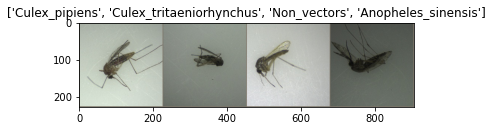

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['TrainVal']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['TrainVal', 'Test']:
            if phase == 'TrainVal':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'TrainVal'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'TrainVal':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'TrainVal':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
TrainVal Loss: 1.0995 Acc: 0.5893
Test Loss: 1.3294 Acc: 0.5301

Epoch 1/9
----------
TrainVal Loss: 0.7561 Acc: 0.7245
Test Loss: 1.7736 Acc: 0.5348

Epoch 2/9
----------
TrainVal Loss: 0.6382 Acc: 0.7611
Test Loss: 1.7908 Acc: 0.4875

Epoch 3/9
----------
TrainVal Loss: 0.6403 Acc: 0.7685
Test Loss: 1.7302 Acc: 0.5084

Epoch 4/9
----------
TrainVal Loss: 0.6408 Acc: 0.7564
Test Loss: 1.5622 Acc: 0.5240

Epoch 5/9
----------
TrainVal Loss: 0.6143 Acc: 0.7782
Test Loss: 1.9022 Acc: 0.4976

Epoch 6/9
----------
TrainVal Loss: 0.6084 Acc: 0.7782
Test Loss: 1.6648 Acc: 0.5426

Epoch 7/9
----------
TrainVal Loss: 0.5393 Acc: 0.8003
Test Loss: 1.7018 Acc: 0.5152

Epoch 8/9
----------
TrainVal Loss: 0.5050 Acc: 0.8195
Test Loss: 1.7114 Acc: 0.5216

Epoch 9/9
----------
TrainVal Loss: 0.4898 Acc: 0.8195
Test Loss: 1.6442 Acc: 0.5166

Training complete in 4m 20s
Best val Acc: 0.542568


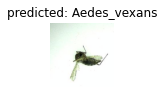

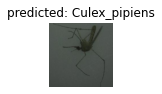

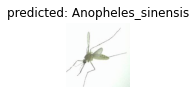

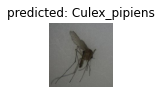

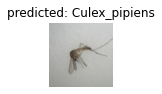

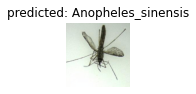

In [10]:
visualize_model(model_conv)

In [11]:
torch.save(model_conv, "model_conv.pth")